# Neural Networks II

### PyTorch Tensor objects for storing and updating model parameters


A special tensor object for which gradients need to be computed allows us to store and update the parameters of our models during training. Such a tensor can be created by just assigning "requires_grad" to True on user-specified initial values. Note that as of now, only tensors of floating point and complex dtype can require gradients. In the following code.

In [1]:
import torch

a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True) 
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


Notice that "requires_grad" is set to False by default. This value can be efficiently set to True by running "requires_grad_()".

In [2]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)
w.requires_grad_()
print(w.requires_grad)

False
True


## Computing gradients via automatic differentiation


### Computing the gradients of the loss with respect to variables
PyTorch supports automatic differentiation, which can be thought of as an implementation of the chain rule for computing gradients of nested functions. To compute these gradients, we can call the "backward" method from the "torch.autograd" module. It computes the sum of gradients of the given tensor with regard to leaf nodes (terminal nodes) in the graph.

In [3]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b) # forward pass
 
loss = (y-z).pow(2).sum() # the sum is for multiple output and redundant here
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)
tensor([-0.5600], grad_fn=<MulBackward0>)


### Understanding automatic differentiation
Automatic differentiation represents a set of computational techniques for computing gradients of arbitrary arithmetic operations. During this process, gradients of a computation (expressed as a series of operations) are obtained by accumulating the gradients through repeated applications of the chain rule. To better understand the concept behind automatic differentiation, let’s consider a series of nested computations, $y(x) = f(g(h(x)))$, with input $x$ and output $y$. This can be broken into a series of steps:
Hence,
\begin{align*}
\frac{dy}{dx} = \frac{df}{dg} \times \frac{dg}{dh} \times \frac{dh}{dx}
\end{align*}

### Adversarial examples
Computing gradients of the loss with respect to the input example is used for generating adversarial examples (or adversarial attacks). In computer vision, adversarial examples are examples that are generated by adding some small, imperceptible noise (or perturbations) to the input example, which results in a deep NN misclassifying them. Covering adversarial examples is beyond the scope of this book, but if you are interested, you can find the original paper by Christian Szegedy et al., Intriguing properties of neural networks at https://arxiv.org/pdf/1312.6199.pdf.

## Simplifying implementations of common architectures via the "torch.nn" module
We have already seen some examples of building a feedforward NN model (for instance, a multilayer perceptron) and defining a sequence of layers using the "nn.Module" class. Before we take a deeper dive into "nn.Module", let’s briefly look at another approach for conjuring those layers via "nn.Sequential".

### Implementing models based on "nn.Sequential"
With "nn.Sequential" (https://pytorch.org/docs/master/generated/torch.nn.Sequential.html#sequential) the layers stored inside the model are connected in a cascaded way. In the following example, we will build a model with two densely (fully) connected layers:

In [4]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

### Choosing a loss function
The mean-square loss function is generally used for regreesion. The family of cross-entropy loss functions supplies the possible choices for classification tasks. You can also compare different loss functions by other metrics, e.g., Area Under the Curve (AUC) or cross validation error to compare different loss functions. 

### Solving an XOR classification problem
The XOR classification problem is a classic problem for analyzing the capacity of a model with regard to capturing the nonlinear decision boundary between two classes. We generate a toy dataset of 200 training examples with two features (x0, x1) drawn from a uniform distribution between [–1, 1). Then, we assign the ground truth label for training example i according to the following rule:
$$
y^{(i)}=
\begin{cases}
0 \quad \text{if } x_0^{(i)}\times x_1^{(i)} < 0 \\
1 \quad \text{otherwise}
\end{cases}
$$

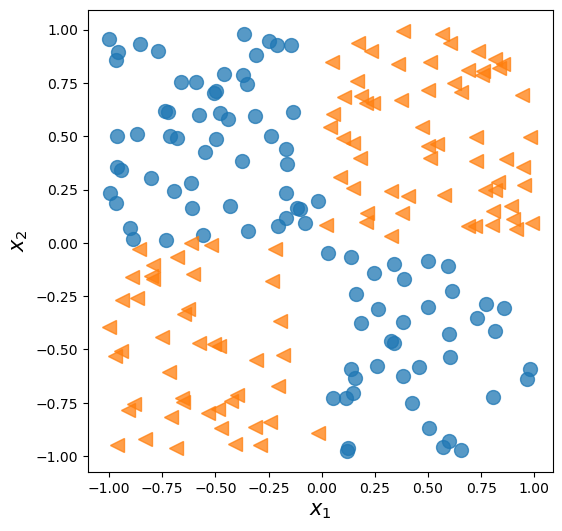

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [6]:
from torch.utils.data import DataLoader, TensorDataset
 
    
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Deciding on model architecture:

In [7]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [8]:
loss_fn = nn.BCELoss() #Binary Cross Entropy loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [9]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

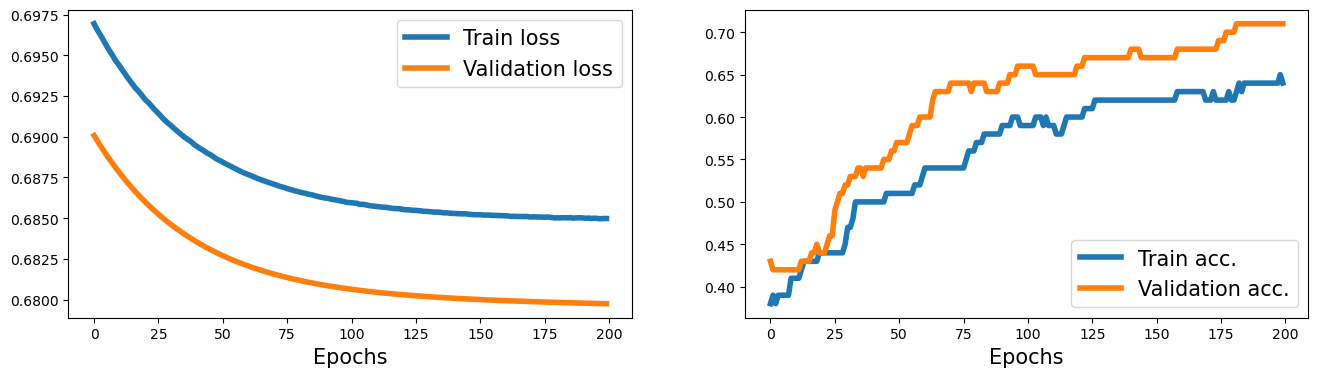

In [10]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

As you can see, a simple model with no hidden layer can only derive a linear decision boundary, which is unable to solve the XOR problem. As a consequence, we can observe that the loss terms for both the training and the validation datasets are very high, and the classification accuracy is very low. 

To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear activation functions. The "universal approximation theorem" states that a feedforward NN with a single hidden layer and a relatively large number of hidden units can approximate arbitrary continuous functions relatively well. Thus, one approach for tackling the XOR problem more satisfactorily is to add a hidden layer and compare different numbers of hidden units until we observe satisfactory results on the validation dataset. Adding more hidden units would correspond to increasing the width of a layer. 

Alternatively, we can also add more hidden layers, which will make the model deeper. The advantage of making a network deeper rather than wider is that fewer parameters are required to achieve a comparable model capacity. However, a downside of deep (versus wide) models is that deep models are prone to vanishing and exploding gradients, which make them harder to train.

In [11]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [12]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

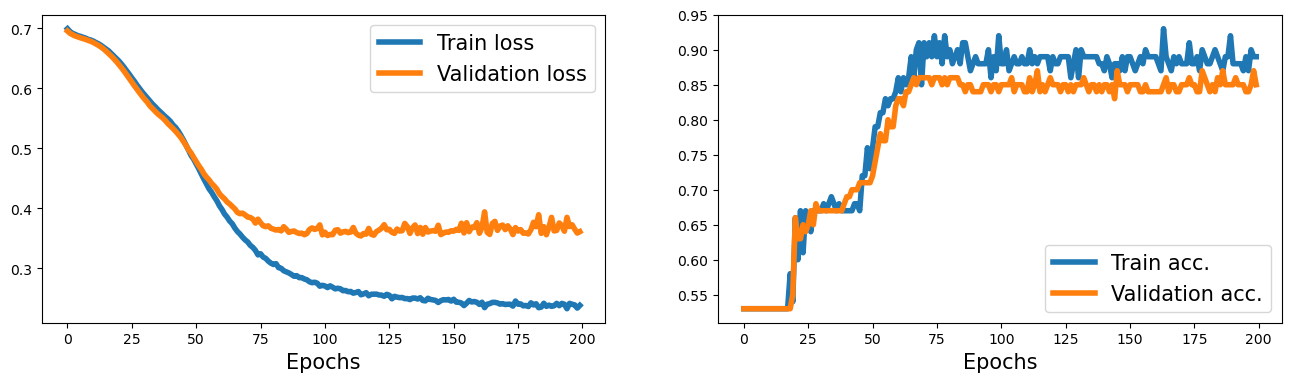

In [13]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

### Making model building more flexible with "nn.Module"
In the previous example, we use "PyTorch.Sequential" class to create fully connexted NN with multiple layers. Alternatively, we an create  more complex models by subclassing "nn.Module". 

In [14]:
class MyModule(nn.Module): #subclasing
    def __init__(self):   # the __init__ methos is a constructor
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l) # NN architecture as a class attribute 

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
            
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [16]:
#conda install mlxtend -c conda-forge #install mlxtend library for visuaization

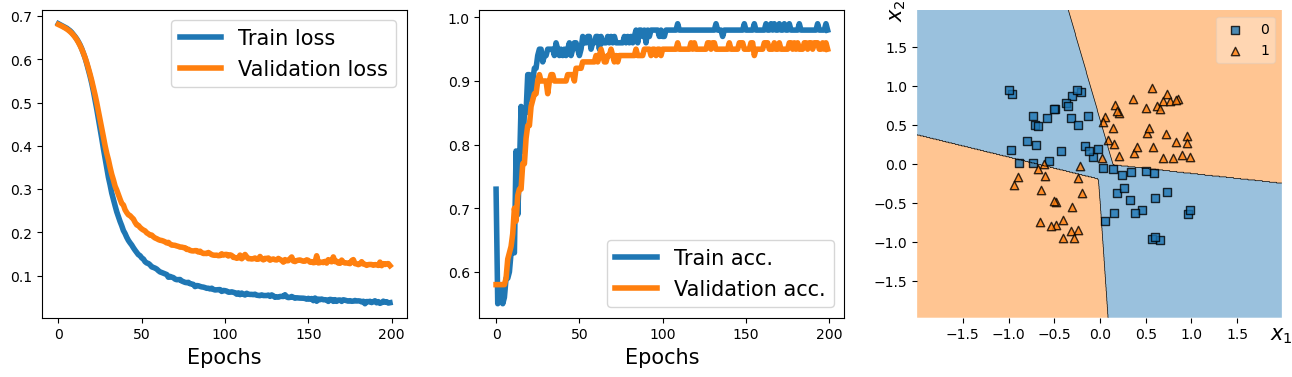

In [18]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()
